In [2]:
!pip freeze > requirements.txt # Save the requirements in a file for jpyyer notebook

zsh:1: /Users/erdo/Desktop/vub-mac-pro-14/second-year/second-semester/bioinformatics/ReProduceProject/bioEnv/bin/pip: bad interpreter: /Users/erdo/Desktop/vub-mac-pro-14/second-year/second-semester/bioinformatics/project/bioEnv/bin/python3.11: no such file or directory


In [15]:
%pip install matplotlib # Install matplotlib for jupyter notebook



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt
import json



In [17]:
# Function to create a time-series for a single column of data
def create_time_series(single_col, num_splits, time_lag, max_lag):
    segment_length = len(single_col) // num_splits
    time_series = []
    for index in range(num_splits):
        # Extract a segment of the data with a time lag
        segment = single_col[index*segment_length+time_lag : segment_length+index*segment_length+time_lag-max_lag]
        # Append the segment to the time series
        time_series.extend(segment)
    return pd.Series(time_series)


# Function to preprocess the gene expression data
def preprocess_expression_data(expression_matrix, num_splits, max_lag):
    new_columns = []
    for gene_name in expression_matrix.columns:
        for lag_index in range(max_lag):
            # Create a time-series for each gene
            new_column = create_time_series(expression_matrix[gene_name], num_splits, lag_index, max_lag)
            new_column.name = gene_name + '_' + str(max_lag-lag_index)
            new_columns.append(new_column)
    # Concatenate all new columns into a DataFrame
    preprocessed_data = pd.concat(new_columns, axis=1)
    return preprocessed_data






In [18]:
# Main function to run the BiXGBoost algorithm
def run_BiXGBoost(expression_file, num_samples, output_file):
    # Read the gene expression data from a file
    gene_expression_data = pd.read_csv(expression_file,  sep='\t')
    scores = {}
    # Loop over each gene in the data
    for index in range(len(gene_expression_data.columns)):
        # Copy the gene expression data
        copied_data = gene_expression_data.copy()
        
        # Create a time-series for the target gene
        target_gene_series = create_time_series(gene_expression_data[gene_expression_data.columns[index]], num_samples, 2, 2)
        
        # Normalize the target gene data
        normalized_target_gene = (target_gene_series - target_gene_series.mean()) / target_gene_series.std()
        
        # Preprocess the gene expression data
        preprocessed_data = preprocess_expression_data(copied_data, num_samples, 2)
        
        # Create and train an XGBoost model
        xgboost_model = xgb.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.0001, subsample=0.8, seed=42)
        xgboost_model.fit(preprocessed_data, normalized_target_gene)
        
        # Evaluate the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared
        predictions = xgboost_model.predict(preprocessed_data)
        mse = mean_squared_error(predictions, normalized_target_gene)
        rmse = sqrt(mse)
        r2 = r2_score(normalized_target_gene, predictions)
        
        # Store the scores for this gene
        scores[gene_expression_data.columns[index]] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
        print('XGBoost: ',gene_expression_data.columns[index], mse, rmse, r2)

    # Save the scores to a file
    # with open(output_file, 'w') as f:
    #     for gene, metrics in scores.items():
    #         f.write(f"{gene}: {metrics}\n")

    # Write the scores to a JSON file
    with open(output_file, 'w') as f:
        json.dump(scores, f)

    return scores


In [19]:
# Main function to run the Random Forest algorithm
def run_RandomForest(expression_file, num_samples,output_file):
    # Read the gene expression data from a file
    gene_expression_data = pd.read_csv(expression_file,  sep='\t')
    scores = {}
    # Loop over each gene in the data
    for index in range(len(gene_expression_data.columns)):
        # Copy the gene expression data
        copied_data = gene_expression_data.copy()
        
        # Create a time-series for the target gene
        target_gene_series = create_time_series(gene_expression_data[gene_expression_data.columns[index]], num_samples, 2, 2)
        
        # Normalize the target gene data
        normalized_target_gene = (target_gene_series - target_gene_series.mean()) / target_gene_series.std()
        
        # Preprocess the gene expression data
        preprocessed_data = preprocess_expression_data(copied_data, num_samples, 2)
        
        # Create and train an XGBoost model
        random_forest_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        random_forest_model.fit(preprocessed_data, normalized_target_gene)
        
        # Evaluate the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared
        predictions = random_forest_model.predict(preprocessed_data)
        mse = mean_squared_error(predictions, normalized_target_gene)
        rmse = sqrt(mse)
        r2 = r2_score(normalized_target_gene, predictions)
        
        # Store the scores for this gene
        scores[gene_expression_data.columns[index]] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
        print('RandomForest: ',gene_expression_data.columns[index], mse, rmse, r2)
        
    with open(output_file, 'w') as f:
        json.dump(scores, f)

    return scores

In [20]:
# Run the BiXGBoost function
# run_BiXGBoost('insilico_size100_1_timeseries.txt', 10, 'BiXGBoost_scores_output.json')



In [21]:
# Run the RandomForest function
# run_RandomForest('insilico_size100_1_timeseries.txt', 10,'BiRandomForest_scores_output.json')

In [23]:
# Function to read scores from a file
def read_scores(file_name):
    with open(file_name, 'r') as f:
        scores = json.load(f)
    return scores

In [32]:
def visualize_scores_without_grouped_genes():
    # Read the scores
    xgboost_scores = read_scores('BiXGBoost_scores_output.json')
    random_forest_scores = read_scores('BiRandomForest_scores_output.json')
    
    # Get the gene names from the keys of the dictionaries
    genes = list(xgboost_scores.keys())
    
    metrics = ['MSE', 'RMSE', 'R2']
    
    for metric in metrics:
        fig, ax = plt.subplots()
    
        # Set the figure size
        fig.set_size_inches(20, 10)  # Increase the size of the figure
    
        # Set the position of the bars on the x-axis
        bar_width = 0.35
        r1 = np.arange(len(genes))  # the label locations
        r2 = [x + bar_width for x in r1]
    
        # Make the plot
        rects1 = ax.bar(r1, [xgboost_scores[gene][metric] for gene in genes], bar_width, label='XGBoost')
        rects2 = ax.bar(r2, [random_forest_scores[gene][metric] for gene in genes], bar_width, label='Random Forest')
    
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Genes')
        ax.set_ylabel(metric.upper() + ' Scores')
        ax.set_title(metric.upper() + ' Scores by Genes and Models')
        ax.set_xticks([r + bar_width / 2 for r in range(len(genes))])
        ax.set_xticklabels(genes, rotation=45)  # Rotate the labels
        ax.legend()
    
        # Show the plot
        plt.show()

In [30]:
def visualize_scores_with_grouped_genes():
    # Read the scores from the output files
    xgboost_scores = read_scores('BiXGBoost_scores_output.json')
    random_forest_scores = read_scores('BiRandomForest_scores_output.json')
    
    # Extract the gene names from the keys of the score dictionaries
    all_genes = list(xgboost_scores.keys())
    
    # Define the metrics we're interested in
    metrics_to_plot = ['MSE', 'RMSE', 'R2']
    
    # Group the genes into groups of 10
    gene_groups = [all_genes[i:i + 10] for i in range(0, len(all_genes), 10)]
    gene_group_labels = ['G' + str(i*10+1) + '-G' + str((i+1)*10) for i in range(len(gene_groups))]
    
    for metric in metrics_to_plot:
        fig, ax = plt.subplots()
    
        # Set the figure size
        fig.set_size_inches(20, 10)
    
        # Set the position of the bars on the x-axis
        bar_width = 0.35
        bar_positions_xgboost = np.arange(len(gene_group_labels))
        bar_positions_random_forest = [x + bar_width for x in bar_positions_xgboost]
    
        # Calculate the average scores for each group of genes
        avg_scores_xgboost = [np.mean([xgboost_scores[gene][metric] for gene in gene_group]) for gene_group in gene_groups]
        avg_scores_random_forest = [np.mean([random_forest_scores[gene][metric] for gene in gene_group]) for gene_group in gene_groups]
    
        # Plot the bars for each model
        ax.bar(bar_positions_xgboost, avg_scores_xgboost, bar_width, label='XGBoost')
        ax.bar(bar_positions_random_forest, avg_scores_random_forest, bar_width, label='Random Forest')
    
        ax.set_xlabel('Gene Groups')
        ax.set_ylabel(metric.upper() + ' Scores')
        ax.set_title(metric.upper() + ' Scores by Gene Groups and Models')
        ax.set_xticks([r + bar_width / 2 for r in range(len(gene_group_labels))])
        ax.set_xticklabels(gene_group_labels, rotation=45)
        ax.legend()
    
        plt.show()


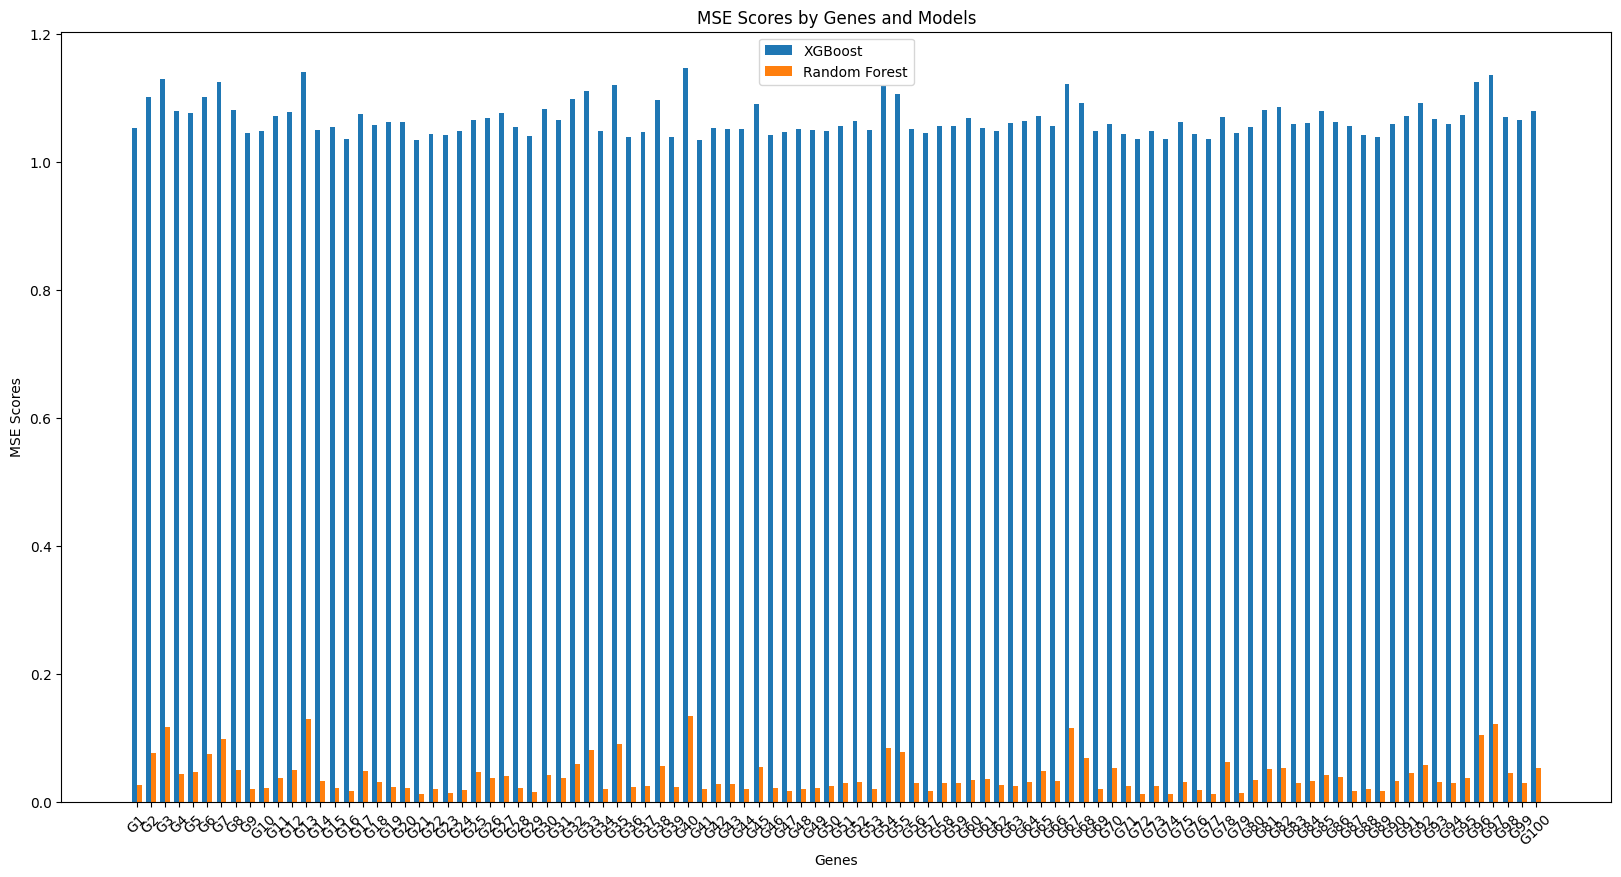

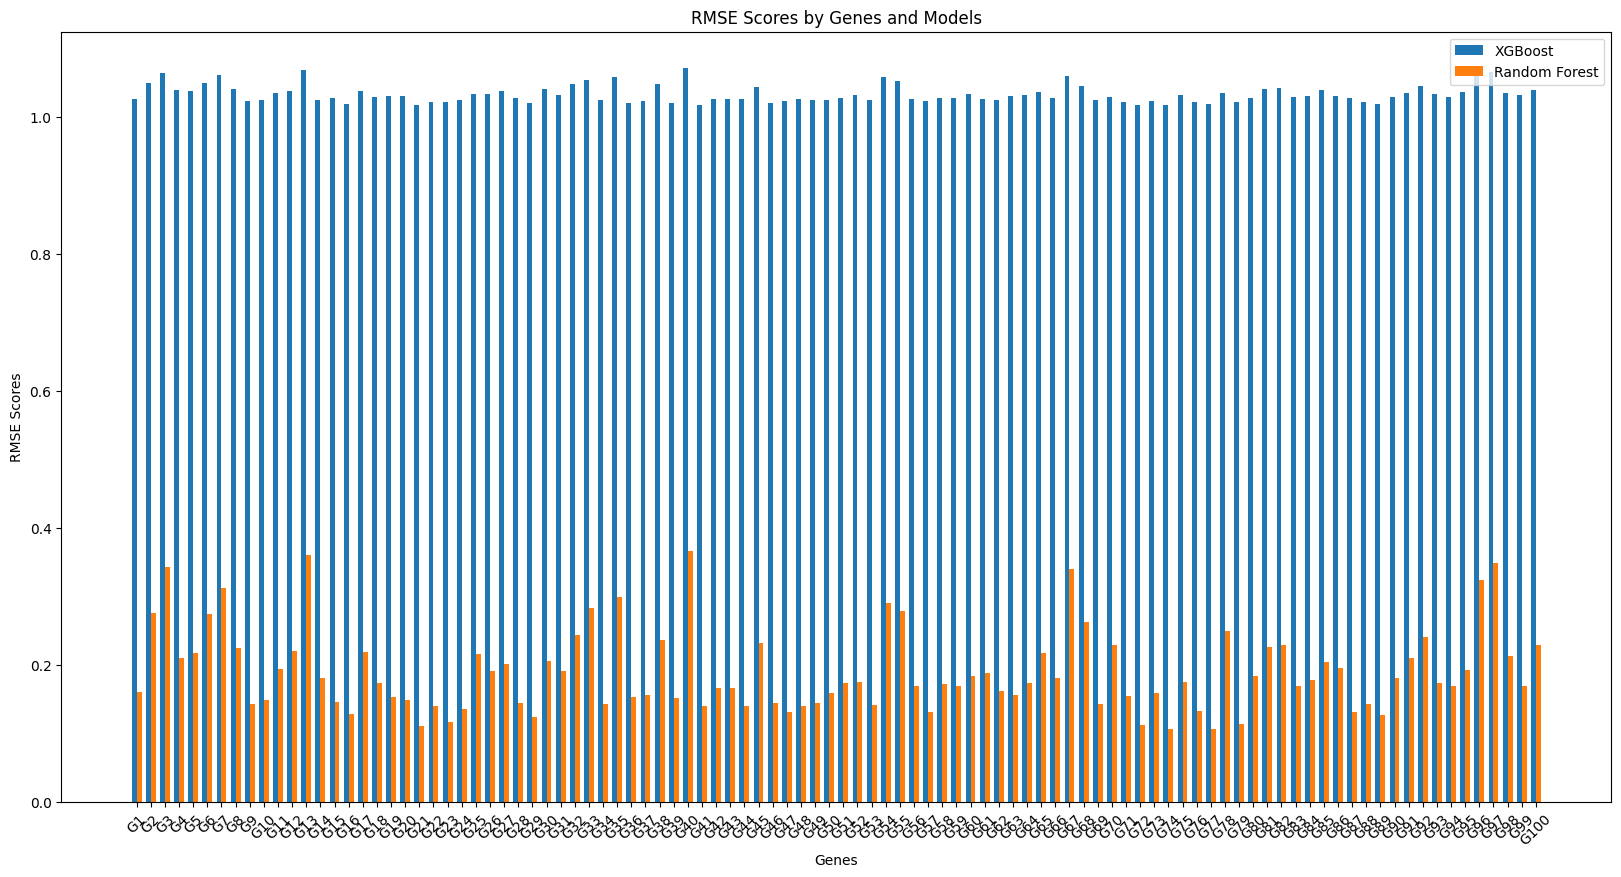

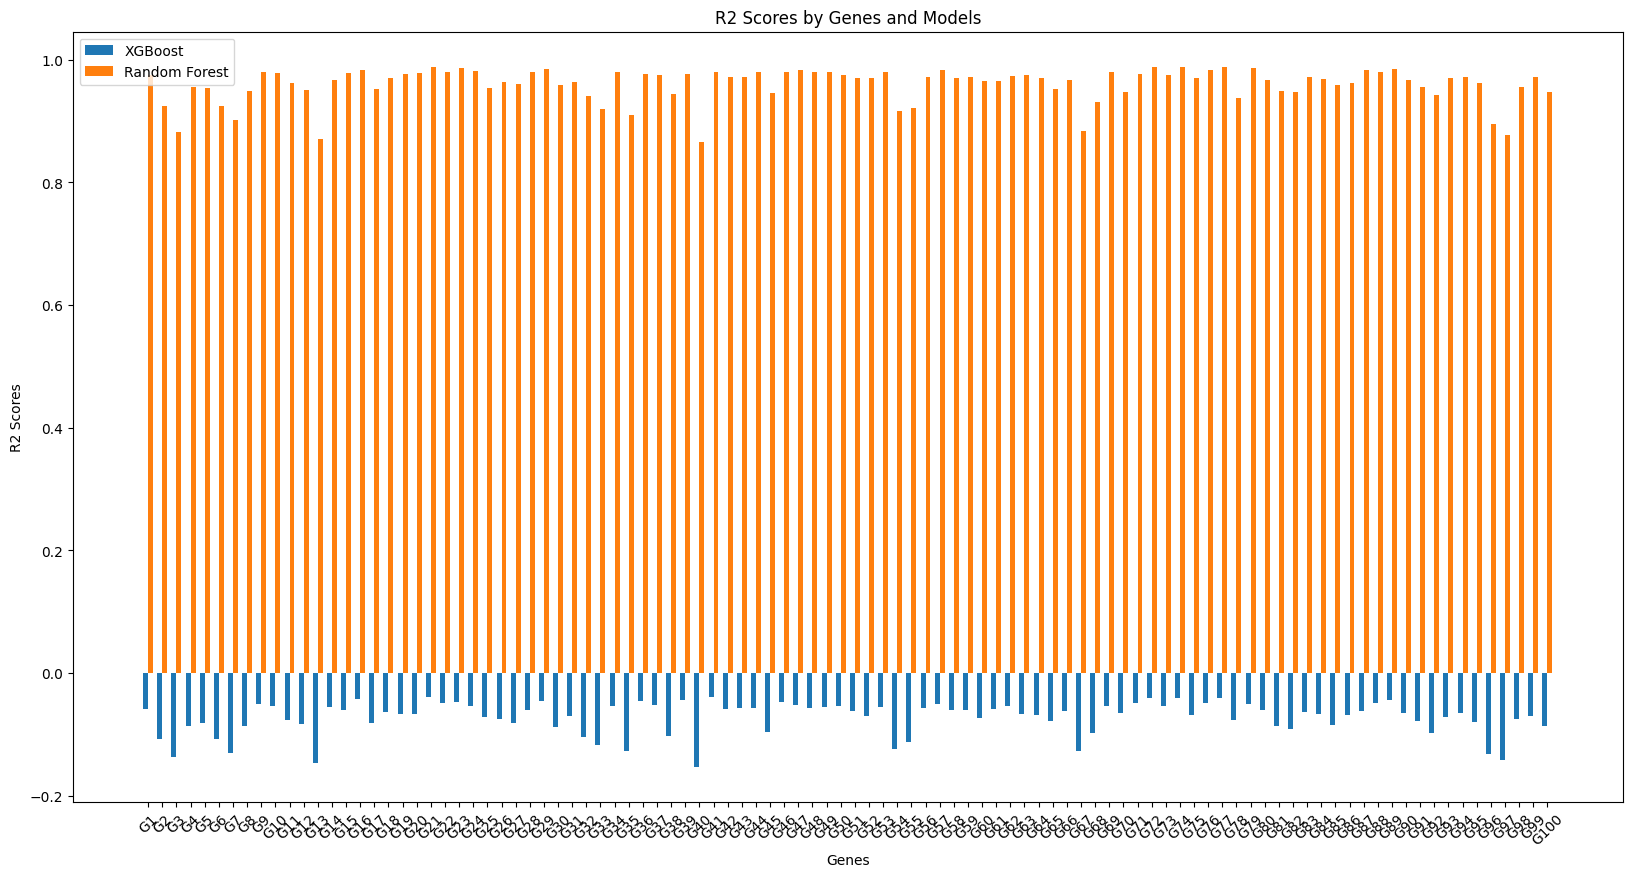

In [33]:
# visualize_scores_without_grouped_genes()

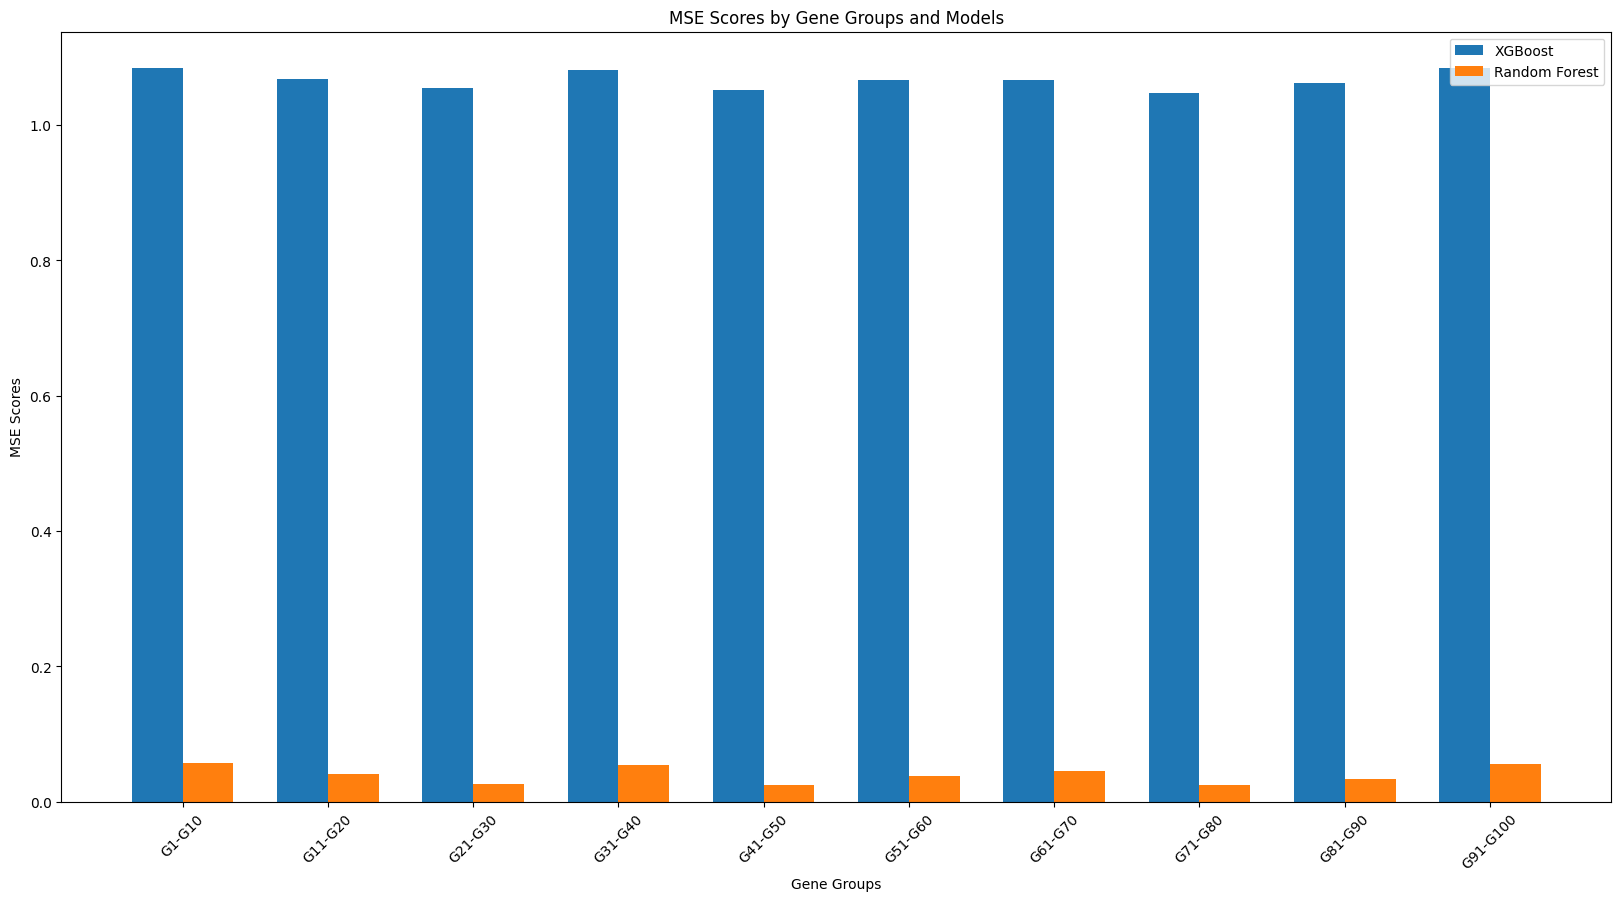

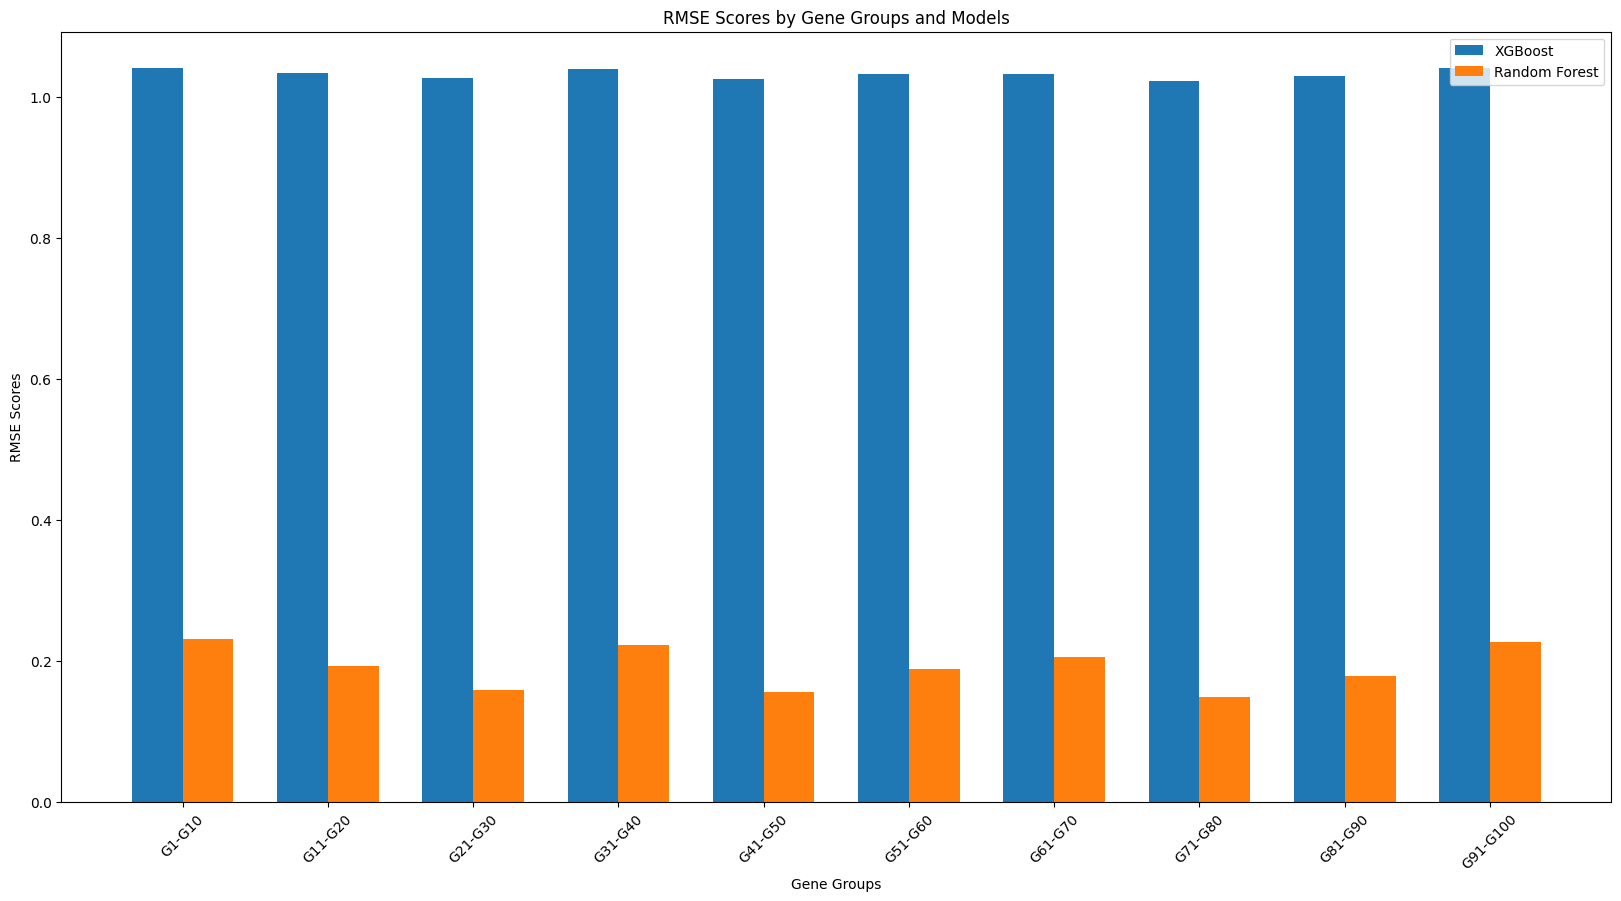

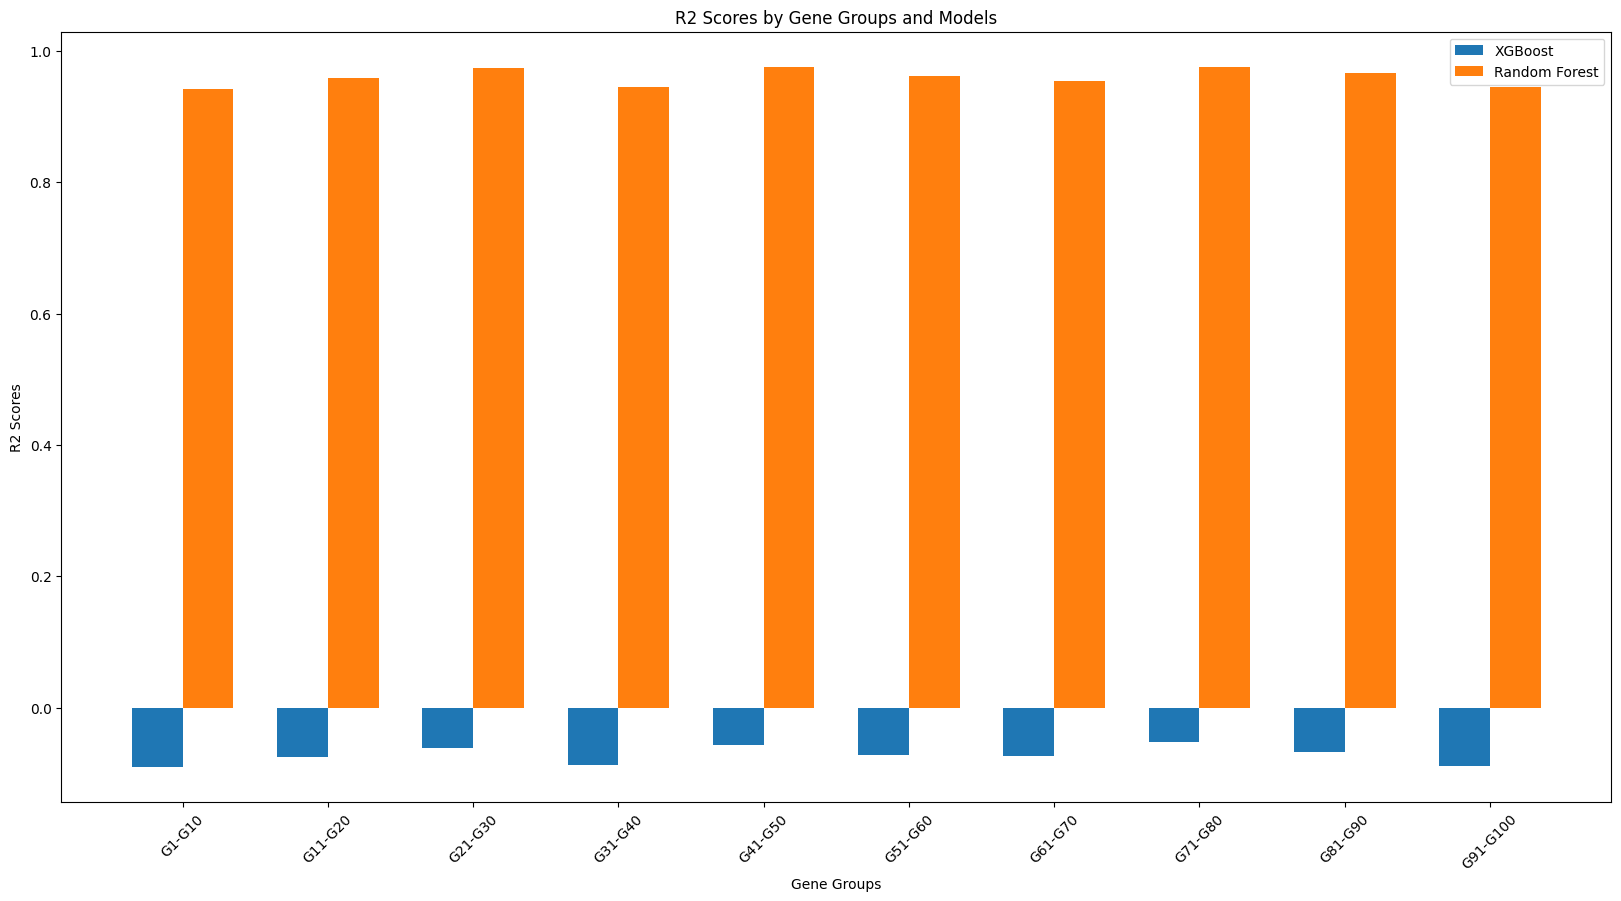

In [31]:
visualize_scores_with_grouped_genes()